# 1-0. Import

In [1]:
import os.path as osp
import openslide
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.filters import threshold_otsu

from openslide.deepzoom import DeepZoomGenerator

import cv2
from keras.utils.np_utils import to_categorical

# network

from keras.models import Sequential
from keras.layers import Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D

# train

from sklearn.model_selection import StratifiedShuffleSplit
from datetime import datetime

# evaluate

import matplotlib.gridspec as gridspec
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

import math
from PIL import Image
from xml.etree.ElementTree import ElementTree, Element, SubElement
from io import BytesIO


from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
import keras.backend.tensorflow_backend as K

Using TensorFlow backend.


# 1-1. Data Load

In [3]:
slide_path = 'data/train/image/positive/Slide001.mrxs'
#slide = openslide.open_slide(slide_path)

BASE_TRUTH_DIR = Path('data/train/mask')
truth_path = str(BASE_TRUTH_DIR/'positive/Slide001.png')
#truth = openslide.open_slide(truth_path)

#print("original slide dimensions %dx%d" % slide.dimensions)
#print("original truth dimensions %dx%d" % truth.dimensions)

In [8]:
slide_path = 'data/train/image/positive/Slide001.mrxs'
#slide_path = 'data/train/image/negative/Slide002.mrxs'
truth_path = 'data/train/mask/positive/Slide001.png'
#turth_path = 'data/train/mask/negative/Slide002.png'

# 1-2. Fit Data Shape

- 밑에 a, b 괄호친 부분은 csv 파일 읽고 min_x, min_y 넣어야함 (이게 사실 필요가 없음)

- https://openslide.org/api/python/#module-openslide

- 이부분은 opensilde_test.ipynb 파일에 실험한 것 참고


## Check if works

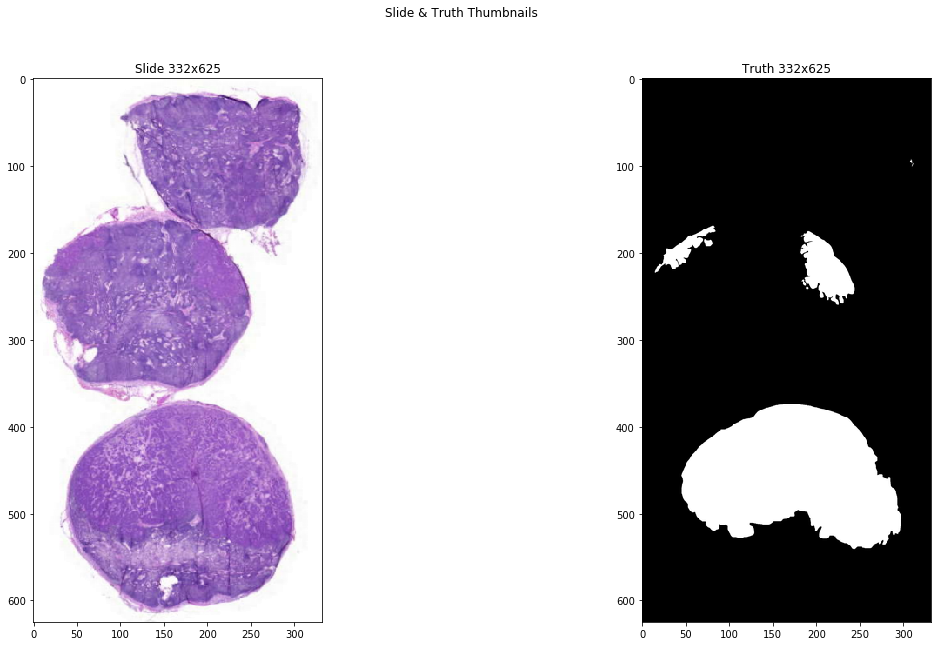

In [10]:

# f, axes = plt.subplots(1, 2, figsize=(20, 10));
# ax = axes.ravel()
# ax[0].imshow(slide4);
# ax[0].set_title('Slide %dx%d' % slide4.size)
# ax[1].imshow(thumbnail_truth.convert('L'), cmap='gray');
# ax[1].set_title('Truth %dx%d' % thumbnail_truth.size)
# f.suptitle('Slide & Truth Thumbnails ');

# 1-3 Patch Gen

- get_thumbnail(size)
: Return an Image containing an RGB thumbnail of the slide.
- patch size 만큼 dimensions 나누기. 1 픽셀이 하나의 패치가 됨 -> DeepZoomGenerator로 다시 확대가능 (patch_size만큼) (2의 거듭제곱으로)
- tissue 검사 - patch['is_tissue'] : ostu method
- tumor 검사 - patch['is_tummor'] 라벨 : mask로 구분
- 경로 추가 저장 = patch['slide_path']
- 최종 training set = concat[patch, patch_y]

In [9]:
PATCH_SIZE = 256
IS_TRAIN = True
def find_patches_from_slide(slide_path, truth_path, patch_size=PATCH_SIZE,filter_non_tissue=True):
    
    slide_contains_tumor = 'pos' in slide_path
    
    ############### read_region을 위한 start, level, size를 구함 #######################
    BOUNDS_OFFSET_PROPS = (openslide.PROPERTY_NAME_BOUNDS_X, openslide.PROPERTY_NAME_BOUNDS_Y)
    BOUNDS_SIZE_PROPS = (openslide.PROPERTY_NAME_BOUNDS_WIDTH, openslide.PROPERTY_NAME_BOUNDS_HEIGHT)

    if slide_contains_tumor:
        with openslide.open_slide(slide_path) as slide:
            start = (int(slide.properties.get('openslide.bounds-x',0)),int(slide.properties.get('openslide.bounds-y',0)))
            level = np.log2(patch_size) 
            level = int(level)
            
            size_scale = tuple(int(slide.properties.get(prop, l0_lim)) / l0_lim
                            for prop, l0_lim in zip(BOUNDS_SIZE_PROPS,
                            slide.dimensions))
            _l_dimensions = tuple(tuple(int(math.ceil(l_lim * scale))
                            for l_lim, scale in zip(l_size, size_scale))
                            for l_size in slide.level_dimensions)
            size = _l_dimensions[level]
            
            slide4 = slide.read_region(start,level,size) 
    else :
        with openslide.open_slide(slide_path) as slide:
            start = (0,0)
            level = np.log2(patch_size) 
            level = int(level)
            
            size_scale = (1,1)
            _l_dimensions = tuple(tuple(int(math.ceil(l_lim * scale))
                            for l_lim, scale in zip(l_size, size_scale))
                            for l_size in slide.level_dimensions)
            size = _l_dimensions[level]
            
            slide4 = slide.read_region(start,level,size) 
    ####################################################################################
    
    
    # is_tissue 부분 
    slide4_grey = np.array(slide4.convert('L'))
    binary = slide4_grey > 0  # black이면 0임
    
    # 검은색 제외하고 흰색영역(배경이라고 여겨지는)에 대해서도 작업해주어야함.
    slide4_not_black = slide4_grey[slide4_grey>0]
    thresh = threshold_otsu(slide4_not_black)
    
    I, J = slide4_grey.shape
    for i in range(I):
        for j in range(J):
            if slide4_grey[i,j] > thresh :
                binary[i,j] = False
    patches = pd.DataFrame(pd.DataFrame(binary).stack())
    patches['is_tissue'] = patches[0]
    patches.drop(0, axis=1,inplace =True)
    patches.loc[:,'slide_path'] = slide_path

    # is_tumor 부분
    if slide_contains_tumor:
        with openslide.open_slide(truth_path) as truth:
            thumbnail_truth = truth.get_thumbnail(size) 
        
        patches_y = pd.DataFrame(pd.DataFrame(np.array(thumbnail_truth.convert("L"))).stack())
        patches_y['is_tumor'] = patches_y[0] > 0
        
        # mask된 영역이 애매할 수도 있으므로
        patches_y['is_all_tumor'] = patches_y[0] == 255
        patches_y.drop(0, axis=1, inplace=True)
        samples = pd.concat([patches, patches_y], axis=1) #len(samples)
    else:
        samples = patches
        #dfmi.loc[:,('one','second')] = value
        samples.loc[:,'is_tumor'] = False
        samples.loc[:,'is_all_tumor'] = False
    
    if filter_non_tissue:
        samples = samples[samples.is_tissue == True] # remove patches with no tissue #samples = samples[samples.is_tissue == True]
    
    filter_only_all_tumor = True

    if filter_only_all_tumor :
        samples['tile_loc'] = list(samples.index)
        all_tissue_samples1 = samples[samples.is_tumor==False]
        all_tissue_samples1 = all_tissue_samples1.append(samples[samples.is_all_tumor==True])
        
        all_tissue_samples1.reset_index(inplace=True, drop=True)
    
    return all_tissue_samples1

In [10]:
all_tissue_samples = find_patches_from_slide(slide_path,truth_path)
print('Total patches in slide: %d' % len(all_tissue_samples)) 
all_tissue_samples.iloc[:10]
all_tissue_samples.is_tumor.value_counts() 

#3초만에 뽑음

Total patches in slide: 105213


False    74490
True     30723
Name: is_tumor, dtype: int64

In [11]:
all_tissue_samples.head(3)

is_tissue                               slide_path  is_tumor  is_all_tumor  \
0       True  data/train/image/positive/Slide001.mrxs     False         False   
1       True  data/train/image/positive/Slide001.mrxs     False         False   
2       True  data/train/image/positive/Slide001.mrxs     False         False   

    tile_loc  
0  (17, 165)  
1  (17, 166)  
2  (17, 167)

# check the is_tissue part

- 원래 이미지를 convert하면 흰색(배경)이미지는 255로 높은 값을 가지게 됨
- otsu라는 method를 통해서 threshold(이 이상부터는 배경값이라고 여길 수 있는)를 얻고
- 이 threshold(아래 변수에서는 thresh)보다 크면 배경, 아니면 배경 아님
- 그런데 slide에서 slide4를 convert하면 대부분의 배경색이 자체적으로 검은색으로 칠해진것을 확인할 수 있었음
- 따라서 다음과 같이 is_tissue를 판별해줌
    - 1. 일단 grey로 convert후, 0보다 크면 True 아니면 False (검은색 부분 처리)
    - 2. black이 아닌 남은 값들로 otsu method를 통해 threshold 계산 후 배경부분 처리(흰색 부분 처리)

In [ ]:
# slide4
# slide4_grey = np.array(slide4.convert('L'))
# slide4.convert('L')
# slide4_grey.shape # (625, 332)
# thresh = threshold_otsu(slide4_grey)
# binary = slide4_grey > thresh
# binary.shape # (625, 332)
# slide4_not_black = slide4_grey[slide4_grey>0]
# thresh = threshold_otsu(slide4_not_black)
# thresh # 186
# type(slide4_grey)
# binary = slide4_grey > 0
# slide4_grey[0,0]

In [ ]:
# 아래 코드로 패치들중에 배경이 많이 들어간 것을 확인할 수 있었음
# from PIL import Image
# im = Image.fromarray(np.uint8(example_X[26]))
# thresh = threshold_otsu(np.array(im.convert('L')))
# print(thresh) # 6 : 251 10 ; 249 17 : 251 14: 154 23: 152, 24: 190, 25 : 182 28 : 249 30: 123 39 : 195 58 : 162 #180이상은 다시 tissue 아님
# np.max(example_X[1])
# im = Image.fromarray(np.uint8(example_X[6]))
# im.convert('L') # 원래는 이렇게 돼야 정상인데
# np.max(example_X[1])
# im = Image.fromarray(np.uint8(example_X[0]))
# thresh = threshold_otsu(np.array(im.convert('L')))
# binary = np.array(im.convert('L')) > thresh

## Check if works - slide_tile_loc, 

- tile(slide에서 뽑은 패치)와 tile_truth(mask_patch) 간의 매칭이 되지 않아 아래 작업 수행 알게된 사실은 다음 3가지
    - 1. tiles의 shape은 (256, 256) , tiles_truth의 shape은 (16,16) (하지만 truth는 이미 원본 최고레벨 슬라이드의 1/16이므로 이렇게 맞춰줘야 같은 영역을 매칭
    - 2. get_tile 할때는 x,y바꿔서 넣어줘야함
    - 3. tiles의 타일 사이즈 (368, 915) tiles_truth의 타일 사이즈 (333,626) 으로 위에서 thumbnail 얻었을 때보다 x,y가 1씩 큼 그래서 끝부분 확인
    - 4. slide의 타일과  바로 가져오려면 min_offset 고려해서 가져와야함. start / patch_size 만큼 더해줘야함 

In [157]:
# start #(7744, 39056)
# tiles = DeepZoomGenerator(slide,tile_size=256, overlap=0 ,limit_bounds = False)
# tiles_truth = DeepZoomGenerator(truth, tile_size=16, overlap = 0, limit_bounds = False)
# print('tile, truth level # : ',tiles.level_count,
# tiles_truth.level_count) # tile, truth level # :  19 15
# tiles.level_dimensions[18] # (93970, 234042)
# tiles.tile_count # 끝에 잘리는부분도 하나로 만듬 (각 영역이 추가됨)
# tiles_truth.level_tiles[14] # tiles.level_tiles[18]
# tiles.level_tiles[18] # (368, 915)
# tiles.level_dimensions[10] #(368, 915)
# tiles_truth.level_dimensions[10] # (333, 626)
# samples[samples.is_tumor>0].head(5)  # is_tumor > 0 확인
# thumbnail_truth.size # (332, 625) thumbnail_truth = truth.get_thumbnail((truth.dimensions[0] / truth_div, truth.dimensions[1] / truth_div))
# k = pd.DataFrame(pd.DataFrame(np.array(thumbnail_truth.convert("L"))).stack())
# k['tile_loc'] = list(k.index)
# k.reset_index(inplace=True, drop=True) # tile_loc 은 x,y가 거꾸로 들어감 (height, width) 정보라고 보면됨 (y,x)로 들어감
# k = k[k[0]>0]
# k


In [159]:
# visual 
# f, axes = plt.subplots(2, 2, figsize=(10, 5))
# axes[0, 0].imshow(tiles.get_tile(tiles.level_count-1, (339, 247))); # turth에서 x는 30만큼, y는 152만큼 더해줘야함
# axes[0, 0].set_title('Tumor Example');
# axes[0, 1].imshow(tiles_truth.get_tile(tiles_truth.level_count-1,(309,95)));
# axes[0, 1].set_title('Truth mask (white=tumor, black=not_tumor)')

# axes[1, 0].imshow(tiles.get_tile(tiles.level_count-1, (362, 777)));
# axes[1, 0].set_title('Tumor Example');
# axes[1, 1].imshow(tiles_truth.get_tile(tiles_truth.level_count-1,(332,625))); # turth 끝 경계
# axes[1, 1].set_title('Truth mask (white=tumor, black=not_tumor)')

# 1-4. Train data Gen

In [221]:
# len(all_tissue_samples1)
# range(len(all_tissue_samples1))
# # https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.Series.html
# type(all_tissue_samples1.slide_path)
# b = all_tissue_samples1.slide_path.unique()
# all_tissue_samples1.iloc[0]

is_tissue                                          True
slide_path      data/train/image/positive/Slide001.mrxs
is_tumor                                          False
is_all_tumor                                      False
tile_loc                                      (17, 165)
Name: 0, dtype: object

In [13]:
image_paths = []
with open('train.txt','r') as f:
    for line in f:
        line = line.rstrip('\n')
        image_paths.append(line)
print('image_path # : ',len(image_paths))

tumor_mask_paths = []

with open('train_mask.txt','r') as f:
    for line in f:
        line = line.rstrip('\n')
        tumor_mask_paths.append(line)
print('mask_patch # : ',len(tumor_mask_paths))

image_path # :  157
mask_patch # :  157


In [21]:
slide_4_list_1 = [[102,104,29,44],[144,55,30,18],[125,56,35,40],[54,65,21,36],[139,82,1,49],[73,108,7,23],[107,117,24,52],[106,103,27,13]
               ,[105,151,15,2],[75,100,41,9],[156,113,32,37],[150,88,39,10],[84,122,5,50],[93,118,53,47],[87,78,45,34],[116,98,48,46],
                [72,131,22,42]]

In [30]:
slide_4_list_2 = [[109,58,14,28],[101,69,11,43],[94,74,3,20],[64,140,17,16],[92,154,8,26],[99,60,0,33],[86,146,25,19],[68,112,38,51],
                 [71,136,31,4],[59,91,12,6]]

In [29]:
slide_4_list_3 = [[143,132,124,85],[95,120,81,77],[97,96,110,83],[152,128,149,155],[153,111,57,138],[134,135,114,76],
                  [123,90,121,61],[147,148,119,142],[66,137,63,80],[70,79,115,133],[129,141,127,145]]

In [31]:
slide_4_test = [[55,55,0,0]]

In [27]:
# 89 130 67 62 126  고려 안됨


In [51]:
NUM_CLASSES = 2 # not_tumor, tumor

def gen_imgs(samples, batch_size, patch_size = PATCH_SIZE, shuffle=True):
    """This function returns a generator that 
    yields tuples of (
        X: tensor, float - [batch_size, patch_size, patch_size, 3]
        y: tensor, int32 - [batch_size, patch_size, patch_size, NUM_CLASSES]
    )
    
    
    input: samples: samples dataframe
    input: batch_size: The number of images to return for each pull
    output: yield (X_train, y_train): generator of X, y tensors
    
    option: base_truth_dir: path, directory of truth slides
    option: shuffle: bool, if True shuffle samples
    """
    
    num_samples = len(samples)
    # 특정 몇개의 slide만 open 해서 쓰기
    # 4개씩 묶었으니까 
    slide_path = 'data/train/image/positive/Slide001.mrxs'
    slide_contains_tumor = 'pos' in slide_path
    
    slide = openslide.open_slide(slide_path)
    #with openslide.open_slide(slide_path) as slide:
    tiles = DeepZoomGenerator(slide,tile_size=patch_size, overlap=0, limit_bounds=False) # 이거 limit_bounds =True하면 저거 굳이 안가져와도 될텐데
    
    start_x = int(slide.properties.get('openslide.bounds-x',0))
    start_y = int(slide.properties.get('openslide.bounds-y',0))
    start_x = start_x / patch_size
    start_y = start_y / patch_size

        #img = tiles.get_tile(tiles.level_count-1, (x,y))
    
    
    if slide_contains_tumor:
        turth_path = 'data/train/mask/positive/Slide001.png'
        truth = openslide.open_slide(truth_path)
        #with openslide.open_slide(truth_path) as truth:
        truth_tiles = DeepZoomGenerator(truth, tile_size=16, overlap=0, limit_bounds=False)
            
    
    
    while 1: # Loop forever so the generator never terminates
        if shuffle:
            samples = samples.sample(frac=1) # shuffle samples

        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset+batch_size]
            images = []
            masks = []
            for _, batch_sample in batch_samples.iterrows(): # 배치마다 deep zoom 하네 약간 비효율적
                
                x, y = batch_sample.tile_loc[::-1]
                x += start_x
                y += start_y
                img = tiles.get_tile(tiles.level_count-1, (x,y))
                
                mask_size_up = np.zeros((patch_size,patch_size))
                a,b=mask_size_up.shape
                # only load truth mask for tumor slides
                if slide_contains_tumor:
                    mask = truth_tiles.get_tile(truth_tiles.level_count-1, batch_sample.tile_loc[::-1])
                    mask = (cv2.cvtColor(np.array(mask), cv2.COLOR_RGB2GRAY) > 0).astype(int)
                        # mask_size_up , 16 to 256
                    for i in range(a):
                        for j in range(b) :
                            k = i//16
                            l = j//16
                            mask_size_up[i,j] = mask[k,l]

                images.append(np.array(img))
                masks.append(mask_size_up)

            X_train = np.array(images)
            y_train = np.array(masks)
            #print('x_train_shape :', X_train.shape)
            
            y_train = to_categorical(y_train, num_classes=2).reshape(y_train.shape[0], patch_size, patch_size, 2) 
            #print('y_train_shape : ',y_train.shape)
            yield X_train, y_train

In [52]:
sample_gen = gen_imgs(all_tissue_samples.sample(1000, random_state=13), 100, shuffle=False)
%time example_X, example_y  = next(sample_gen)

x_train_shape : (100, 256, 256, 3)
y_train_shape :  (100, 256, 256, 2)
Wall time: 3.62 s


In [ ]:
# 30초에서 1/10인 3초만에  실행됨

## Check if right

In [23]:
print('example_X.shape : ',example_X.shape)
print('example_y.shape : ',example_y.shape)

example_X.shape :  (100, 256, 256, 3)
example_y.shape :  (100, 256, 256, 2)


In [ ]:
# example_y.size() s

In [25]:
np.sum(example_y[8].argmax(axis=2))

0

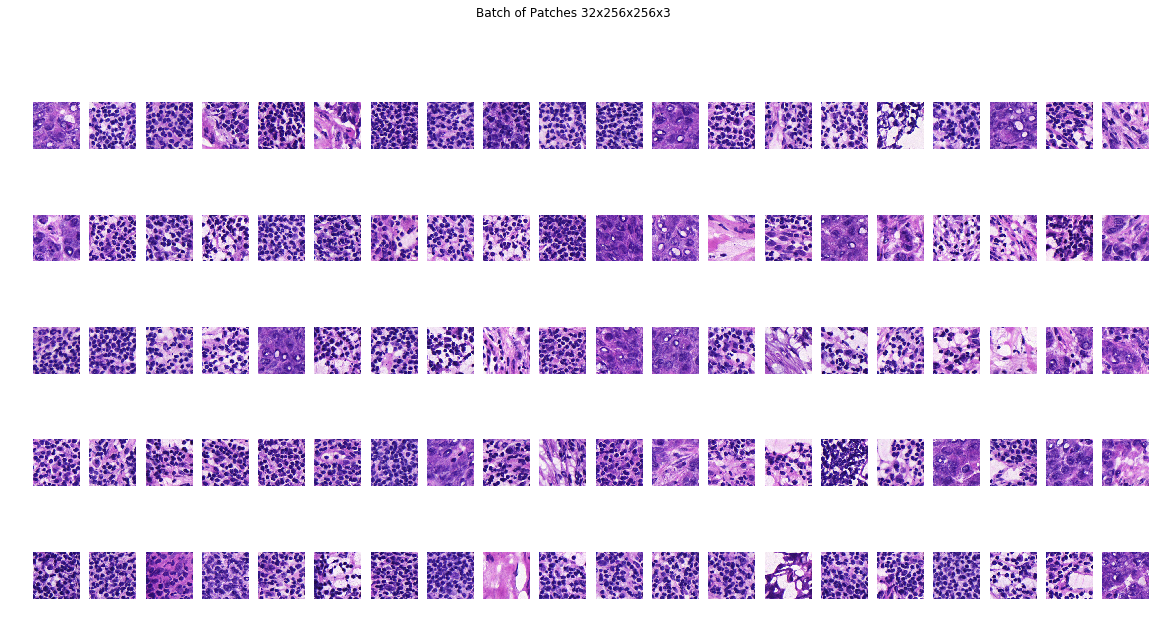

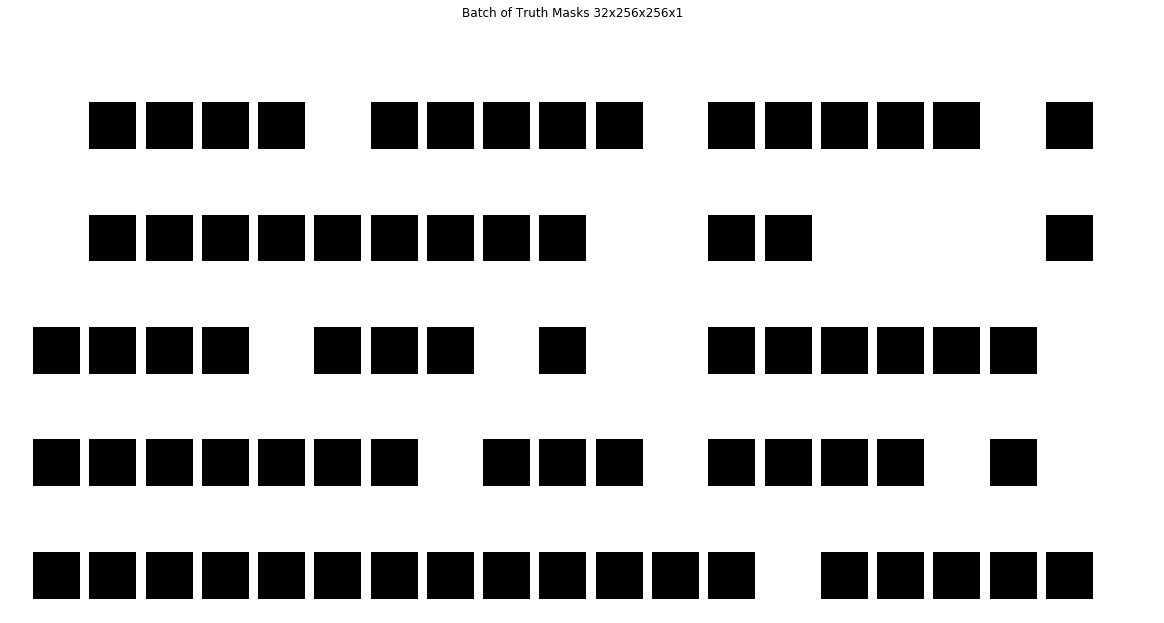

In [26]:
f, axes = plt.subplots(5,20, figsize=(20, 10));
ax = axes.flatten()
for i in range(0, example_X.shape[0]):
    _ = ax[i].imshow(example_X[i]);
    _ = ax[i].axis('off');
f.suptitle('Batch of Patches 32x256x256x3');
    
f, axes = plt.subplots(5, 20, figsize=(20, 10));
ax = axes.flatten()    
for i in range(0, example_X.shape[0]):
    _ = ax[i].imshow(example_y[i].argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    _ = ax[i].axis('off');
f.suptitle('Batch of Truth Masks 32x256x256x1');

- mask 된 부분 약간 이상했음
- mask 가 확실히 흰색인 부분만 학습세트로 써야겠다고 결정
- 혹은 그 mask를 조절해서 원본과 맞춰야함 - 그러기 위해서, deepzoom, read_region, get_thumbnail 다시 다 확인해야함

## 위의 문제 사항 해결완료  

- slide properties 이용해서 min offset 구하기
- get.thumbnail에 소수 이용 가능
- OpenslideTest.ipynb 파일에서 확인할 수 있음

# 1-5. Data Augmentation

---
(camelyon17)
- convert images to horizontal flip
- convert images to vertical flip
- convert images to gray scale randomly (percentage = 10%)
- convert images brightness, contrast, saturation, hue slightly

---
(camelyon16 -google)
- 4 multiples of 90˚ rotations. + left-right flip (8 orientations)
- perturb color : (maximum delta)
  - brighteness 64/255,
  - saturation 0.25,
  - hue 0.04
  - contrast 0.75 
- Jitter : up to 8 pixels.
(- pixel values clipped [0,1], and scaled [-1,1])
---

# 1-6. Sampling

---
(google)
- 먼저 'normal'과 'tumor'를 같은 확률로 뽑고
- 그 라벨의 패치들을 가지고 있는 슬라이드를 랜덤하게 뽑고 (훈련중에 나타나는 패치수들을 한정적으로 만들지 않기 위해) 
- 그 슬라이드들에서 패치들을 샘플링한다.
---
(구현)
- 샘플링 전 데이터 분포 확인 필요
- min slide 몇개 뽑았을 때 원하는 sample size 나오는지 계산
- 


# 2. NetWork

In [ ]:
- U net 구조(지금) #base network도 하나 만들고
- Inception V3 (parameter 수 적은 걸로)
- ResNet

In [62]:
from keras.models import load_model
model = load_model('model0121_2.h5')

In [27]:
# model = Sequential()
# model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(256, 256, 3)))
# model.add(Convolution2D(100, (3, 3), strides=(2, 2), activation='elu', padding='same'))
# model.add(MaxPooling2D())
# model.add(Convolution2D(200, (3, 3), strides=(2, 2), activation='elu', padding='same'))
# model.add(MaxPooling2D())
# model.add(Convolution2D(300, (3, 3), activation='elu', padding='same'))
# model.add(Convolution2D(300, (3, 3), activation='elu',  padding='same'))
# model.add(Dropout(0.2))
# model.add(Convolution2D(2, (1, 1))) # this is called upscore layer for some reason?
# model.add(Conv2DTranspose(2, (31, 31), strides=(16, 16), activation='softmax', padding='same'))

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [63]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 100)     2800      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 100)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 200)       180200    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 200)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 300)       540300    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 300)       810300    
__________

# 3. Train

In [57]:
BATCH_SIZE = 50
N_EPOCHS = 10

In [36]:
slide_path

'data/train/image/positive/Slide001.mrxs'

In [37]:
truth_path

'data/train/mask/positive/Slide001.png'

In [35]:
samples = find_patches_from_slide(slide_path,truth_path)

In [38]:
len(samples)

105213

In [39]:
NUM_SAMPLES = len(samples)

In [43]:
samples = samples.sample(NUM_SAMPLES, random_state=42)
samples.reset_index(drop=True, inplace=True)

In [44]:
samples.is_tumor.value_counts()

False    74490
True     30723
Name: is_tumor, dtype: int64

In [45]:
len(samples)

105213

In [47]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in split.split(samples, samples["is_tumor"]):
        train_samples = samples.loc[train_index]
        validation_samples = samples.loc[test_index]

In [121]:
train_samples.head(3)

is_tissue                               slide_path  is_tumor  \
37156       True  data/train/image/positive/Slide001.mrxs     False   
70070       True  data/train/image/positive/Slide001.mrxs     False   
17886       True  data/train/image/positive/Slide001.mrxs     False   

       is_all_tumor    tile_loc  
37156         False  (528, 190)  
70070         False   (60, 119)  
17886         False  (558, 247)

In [49]:
len(train_samples)

94691

In [50]:
len(validation_samples)

10522

In [34]:
N_EPOCHS

10

In [58]:
BATCH_SIZE

50

In [59]:
train_generator = gen_imgs(train_samples, BATCH_SIZE)

In [60]:
train_generator

<generator object gen_imgs at 0x000001995AB8CF68>

In [64]:
## TODO Add checkpoint mechanism to save old model before generating new

train_generator = gen_imgs(train_samples, BATCH_SIZE)
validation_generator = gen_imgs(validation_samples, BATCH_SIZE)

# Train model
train_start_time = datetime.now()
history = model.fit_generator(train_generator, np.ceil(len(train_samples) / BATCH_SIZE),
    validation_data=validation_generator,
    validation_steps=np.ceil(len(validation_samples) / BATCH_SIZE),
    epochs=5)
train_end_time = datetime.now()
print("Model training time: %.1f minutes" % ((train_end_time - train_start_time).seconds / 60,))

Epoch 1/5
x_train_shape : (50, 256, 256, 3)
x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
y_train_shape :  (50, 256, 256, 2)
   1/1894 [..............................] - ETA: 2:47:07 - loss: 0.1550 - acc: 0.9299x_train_shape : (50, 256, 256, 3)
x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
y_train_shape :  (50, 256, 256, 2)
   2/1894 [..............................] - ETA: 1:32:10 - loss: 0.1618 - acc: 0.9362x_train_shape : (50, 256, 256, 3)
x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)
y_train_shape :  (50, 256, 256, 2)
   3/1894 [..............................] - ETA: 1:27:09 - loss: 0.1732 - acc: 0.9291x_train_shape : (50, 256, 256, 3)
x_train_shape : (50, 256, 256, 3)
y_train_shape : y_train_shape :   (50, 256, 256, 2)(50, 256, 256, 2)

   4/1894 [..............................] - ETA: 1:23:56 - loss: 0.1654 - acc: 0.9334x_train_shape : (50, 256, 256, 3)x_train_shape :
 (50, 256, 256, 3)
y_train_shape : y_train_sh

In [65]:
# Save model
model.save('model0121_2.h5')

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


In [ ]:
# 시각화 해보기

# 4. Evaluate

In [215]:
# 4-1. Visualization A single patches prediction

In [66]:
def predict_from_model(patch, model):
    """Predict which pixels are tumor.
    
    input: patch: 256x256x3, rgb image
    input: model: keras model
    output: prediction: 256x256x1, per-pixel tumor probability
    """
    
    prediction = model.predict(patch.reshape(1, 256, 256, 3))
    prediction = prediction[:, :, :, 1].reshape(256, 256)
    return prediction

def plot_blend(patch, prediction, ax, alpha=0.75):
    """alpha blend patch and prediction.
    https://matplotlib.org/examples/pylab_examples/layer_images.html
    
    input: patch: 256x256x3, rgb image
    input: prediction: 256x256x1, per-pixel tumor probability
    input: ax: maplotlib Axes object
    input: alpha: alpha blend
    """
    
    dx, dy = 0.05, 0.05
    x = np.arange(0, patch.shape[1] - 1, dx)
    y = np.arange(0, patch.shape[0] - 1, dy)
    xmin, xmax, ymin, ymax = np.amin(x), np.amax(x), np.amin(y), np.amax(y)
    extent = xmin, xmax, ymin, ymax

    # fig = plt.figure(frameon=False, figsize=(10, 5))
    Z1 = cv2.cvtColor(patch, code=cv2.COLOR_RGB2GRAY)
    Z2 = prediction

    im1 = ax.imshow(Z1, cmap='gray', extent=extent)
    im2 = ax.imshow(Z2, cmap='jet', alpha=alpha, vmin=0.0, vmax=1.0,
                     extent=extent)
    ax.axis('off');

def plot_patch_with_pred(patch, truth, prediction, title_str='', alpha=0.6):
    """
    input: patch: 256x256x3, rgb image
    input: truth: 256x256x2, onehot output classes (not_tumor, tumor)
    input: prediction: 256x256x1, per-pixel tumor probability
    """
    gs = gridspec.GridSpec(2, 4, width_ratios=[10, 10, 19, 1])
    ax0 = plt.subplot(gs[0, 0])
    ax1 = plt.subplot(gs[0, 1])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1])
    ax4 = plt.subplot(gs[:, 2])
    axc = plt.subplot(gs[:, 3])

    ax0.imshow(patch);
    ax0.set_title('Original')
    
    ax1.imshow(truth.argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    ax1.set_title('Truth mask (white=tumor, black=not_tumor)')
    
    p = ax2.imshow(prediction, cmap='jet', vmin=0, vmax=1);
    ax2.set_title('Prediction heatmap')

    ax3.imshow((prediction > 0.5).astype(np.int), cmap='gray', vmin=0, vmax=1);
    ax3.set_title('Prediction mask (white=tumor, black=not_tumor)')
    
    plot_blend(patch, prediction, ax4, alpha)
    ax4.set_title('Original+Prediction blend')
    
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    fig.suptitle(title_str)
    fig.colorbar(p, cax=axc, orientation="vertical")
    axc.set_title('Probability pixel is tumor')

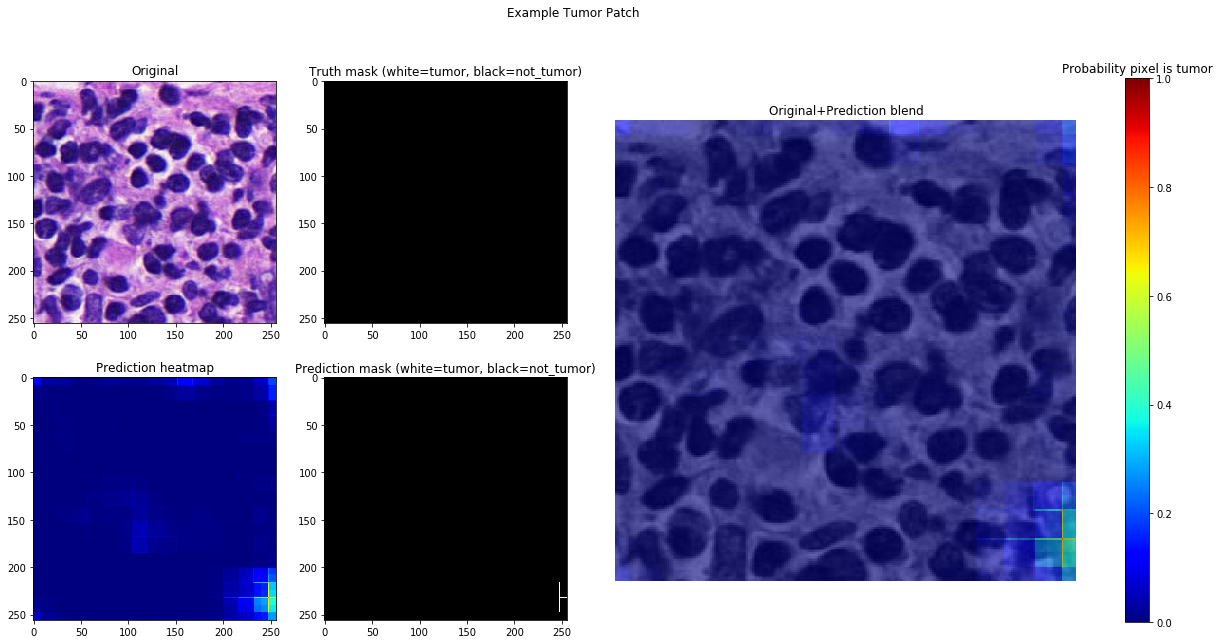

In [63]:
# 3 , 5(0.91) , 8(완전잘못) , 13(0.88) , 16(0.87) 32, 37
example_patch = example_X[49]
example_truth = example_y[49]

prediction = predict_from_model(example_patch, model)
plot_patch_with_pred(example_patch, example_truth, prediction, title_str='Example Tumor Patch')

# 4-3. AUC 계산

- 256 x 256 prediction ; AUC : .983
- 128 x 128 prediction ; AUC : .984

- more training : AUC : 1

In [67]:
from sklearn import metrics

In [68]:
start_x = PATCH_SIZE//4
start_y = PATCH_SIZE//4
pred_size = PATCH_SIZE//2

In [72]:
preds

[0.9998946189880371,
 0.9999986886978149,
 0.006439137272536755,
 0.42630696296691895,
 0.06749484688043594,
 0.5689319968223572,
 0.06308454275131226,
 0.9998112320899963,
 0.3312084972858429,
 0.999874472618103,
 0.018947318196296692,
 0.24976156651973724,
 0.13675905764102936,
 0.9999902248382568,
 0.9997466206550598,
 0.9999833106994629,
 0.9312517642974854,
 0.7147607803344727,
 0.02720840647816658,
 0.4809350371360779,
 0.7679145336151123,
 0.30290287733078003,
 0.9906750321388245,
 0.9688993096351624,
 0.9999973773956299,
 0.9999799728393555,
 0.9999736547470093,
 0.0631207749247551,
 0.025517556816339493,
 0.06313506513834,
 0.9999947547912598,
 0.5347773432731628,
 0.11088690906763077,
 0.5591838359832764,
 0.9999971389770508,
 0.9997444748878479,
 0.038382306694984436,
 0.5531205534934998,
 0.41396453976631165,
 0.9999709129333496,
 0.541570246219635,
 0.9340384006500244,
 0.9999731779098511,
 0.16942621767520905,
 0.11511771380901337,
 0.28107738494873047,
 0.999929785728454

In [69]:
labels= []
preds = []
for i in range(len(example_y)):
    label = np.max(example_y[i].argmax(axis=2))
    labels.append(label)
    prediction = predict_from_model(example_X[i], model)
    pred_X = np.zeros((pred_size,pred_size))
    for x in range(start_x,start_x+pred_size):
        for y in range(start_y, start_y+pred_size):
            pred_X[x-start_x][y-start_y] = prediction[x][y]
    pred_s = pd.Series(pred_X.flatten())
    pred_x_i = np.max(pred_s)
    preds.append(pred_x_i)

In [70]:
# 128,128 으로 예측했을때
y = np.asarray(labels)
pred = np.asarray(preds)
fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
metrics.auc(fpr, tpr)

1.0

In [ ]:
# y = np.asarray(labels)
# pred = np.asarray(preds)
# # 256, 256 으로 예측했을때
# fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
# metrics.auc(fpr, tpr)
# # 0.9838877338877339

# visual

In [73]:
example_patch = example_X[3]
example_truth = example_y[3]
Y = example_truth
small_Y =np.zeros((pred_size,pred_size,2))
for x in range(start_x,pred_size):
    for y in range(start_y, pred_size):
        small_Y[x-start_x][y-start_y][0] = Y[x][y][0]
        small_Y[x-start_x][y-start_y][1] = Y[x][y][1]

In [74]:
for i in range(len(example_y)):
    prediction = predict_from_model(example_patch, model)
    pred_X = np.zeros((pred_size,pred_size))
    for x in range(start_x,start_x+pred_size):
        for y in range(start_y, start_y+pred_size):
            pred_X[x-start_x][y-start_y] = prediction[x][y]

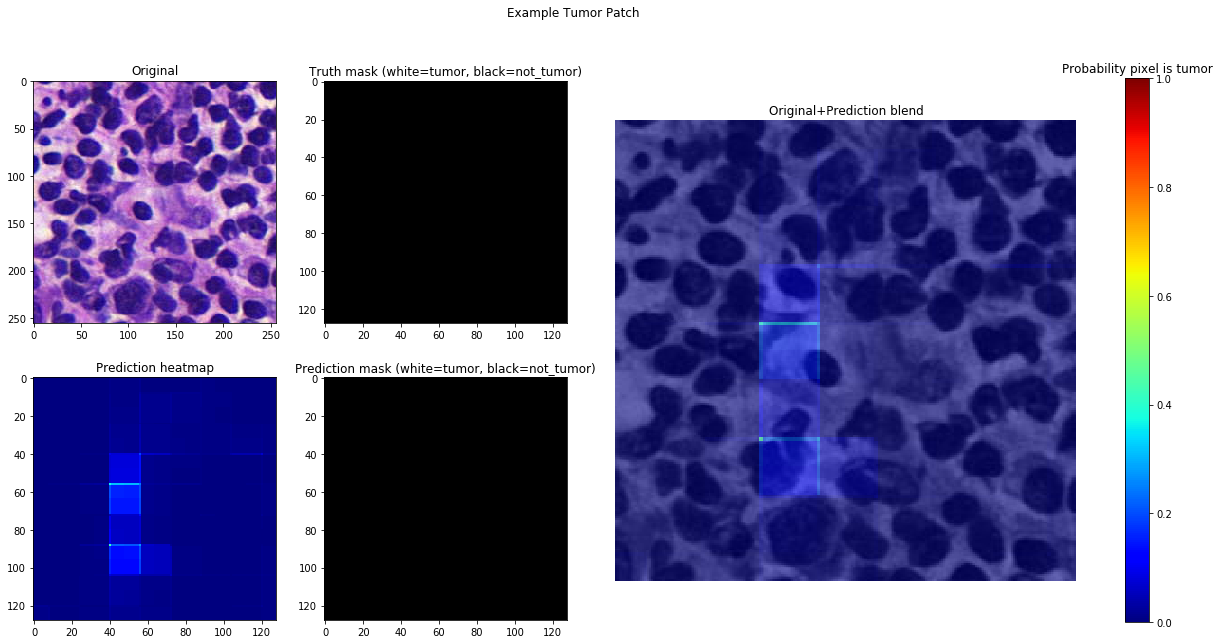

In [75]:
plot_patch_with_pred(example_patch, small_Y, pred_X, title_str='Example Tumor Patch')

In [76]:
predict_max_one[0:10] #3
predict_max_one[10:20]
predict_max_one[20:30] #26
predict_max_one[30:40] #33
predict_max_one[40:50] #42 45
predict_max_one[50:60] #52,53,57
predict_max_one[60:70] #69
predict_max_one[70:80] #72, 75
predict_max_one[80:90] #82
predict_max_one[90:100] #93(positive인데)


NameError: name 'predict_max_one' is not defined

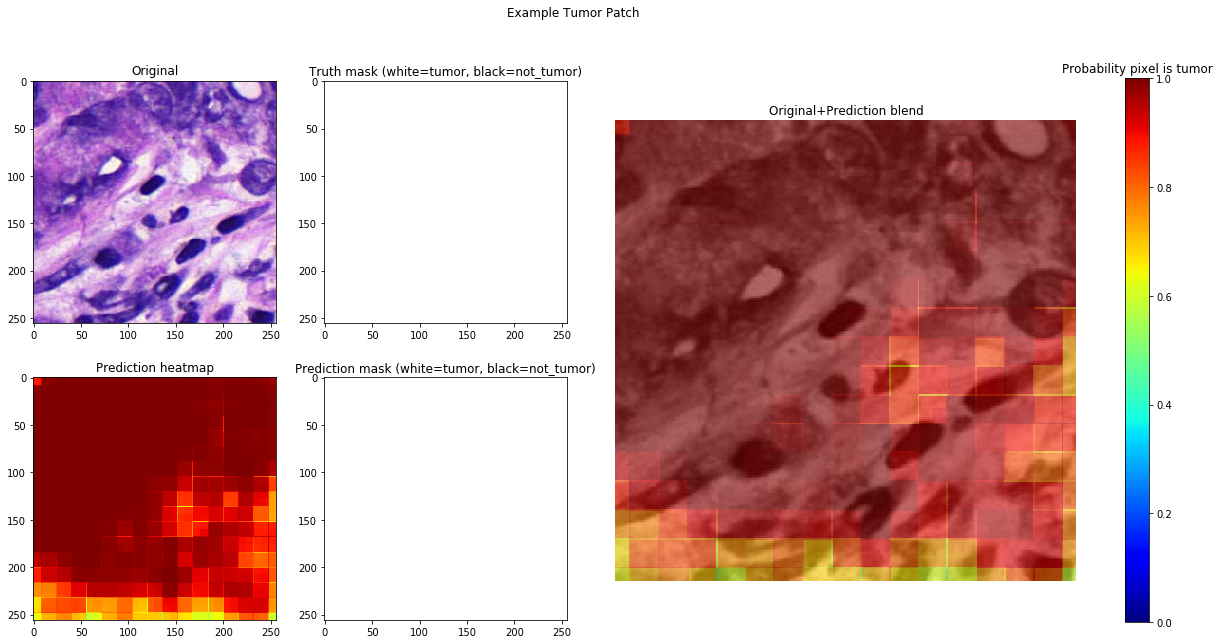

In [113]:
# 3 , 5(0.91) , 8(완전잘못) , 13(0.88) , 16(0.87) 32, 37
example_patch = example_X[34]
example_truth = example_y[34]

prediction = predict_from_model(example_patch, model)
plot_patch_with_pred(example_patch, example_truth, prediction, title_str='Example Tumor Patch')

count    65536.000000
mean         0.011505
std          0.038305
min          0.000024
25%          0.001093
50%          0.002338
75%          0.005775
max          0.791444
dtype: float64


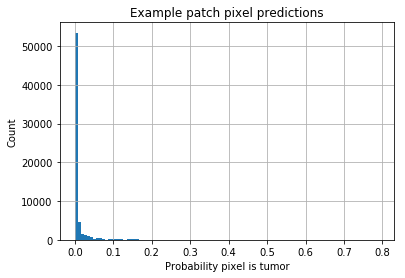

In [57]:
pred_s = pd.Series(prediction.flatten())
print(pred_s.describe())
ax = pred_s.hist(bins=100);
ax.set_title('Example patch pixel predictions');
ax.set_ylabel('Count');
ax.set_xlabel('Probability pixel is tumor');

# 4-2. Performance Metrics

In [ ]:
# threshold = 0.9 로 바꿔보자

In [115]:
def predict_batch_from_model(patches, model):
    """Predict which pixels are tumor.
    
    input: patch: `batch_size`x256x256x3, rgb image
    input: model: keras model
    output: prediction: 256x256x1, per-pixel tumor probability
    """
    predictions = model.predict(patches)
    predictions = predictions[:, :, :, 1]
    return predictions

In [116]:
validation_generator = gen_imgs(validation_samples, BATCH_SIZE)
validation_steps = np.ceil(len(validation_samples) / BATCH_SIZE)

confusion_mtx = np.zeros((2, 2))

for i in tqdm(range(int(validation_steps))):
    X, y  = next(validation_generator)
    preds = predict_batch_from_model(X, model)
    
    y_true = y[:, :, :, 1].ravel()
    y_pred = np.uint8(preds > 0.5).ravel()
    
    confusion_mtx += confusion_matrix(y_true, y_pred, labels=[0, 1])

  0%|                                                                                          | 0/211 [00:00<?, ?it/s]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


  0%|▍                                                                                 | 1/211 [00:10<37:52, 10.82s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


  1%|▊                                                                                 | 2/211 [00:21<37:02, 10.63s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


  1%|█▏                                                                                | 3/211 [00:31<36:21, 10.49s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


  2%|█▌                                                                                | 4/211 [00:41<35:38, 10.33s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


  2%|█▉                                                                                | 5/211 [00:50<34:54, 10.17s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


  3%|██▎                                                                               | 6/211 [01:00<34:27, 10.09s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


  3%|██▋                                                                               | 7/211 [01:11<34:32, 10.16s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


  4%|███                                                                               | 8/211 [01:21<34:42, 10.26s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


  4%|███▍                                                                              | 9/211 [01:31<34:29, 10.25s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


  5%|███▊                                                                             | 10/211 [01:41<34:05, 10.17s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


  5%|████▏                                                                            | 11/211 [01:52<34:18, 10.29s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


  6%|████▌                                                                            | 12/211 [02:02<33:57, 10.24s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


  6%|████▉                                                                            | 13/211 [02:12<33:23, 10.12s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


  7%|█████▎                                                                           | 14/211 [02:22<33:00, 10.05s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


  7%|█████▊                                                                           | 15/211 [02:32<32:36,  9.98s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


  8%|██████▏                                                                          | 16/211 [02:41<32:16,  9.93s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


  8%|██████▌                                                                          | 17/211 [02:51<32:03,  9.92s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


  9%|██████▉                                                                          | 18/211 [03:01<31:49,  9.90s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


  9%|███████▎                                                                         | 19/211 [03:11<31:37,  9.88s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


  9%|███████▋                                                                         | 20/211 [03:21<31:26,  9.87s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 10%|████████                                                                         | 21/211 [03:31<31:13,  9.86s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 10%|████████▍                                                                        | 22/211 [03:40<31:00,  9.84s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 11%|████████▊                                                                        | 23/211 [03:50<30:54,  9.86s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 11%|█████████▏                                                                       | 24/211 [04:00<30:51,  9.90s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 12%|█████████▌                                                                       | 25/211 [04:10<30:43,  9.91s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 12%|█████████▉                                                                       | 26/211 [04:20<30:27,  9.88s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 13%|██████████▎                                                                      | 27/211 [04:30<30:17,  9.88s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 13%|██████████▋                                                                      | 28/211 [04:40<30:05,  9.86s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 14%|███████████▏                                                                     | 29/211 [04:50<29:51,  9.85s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 14%|███████████▌                                                                     | 30/211 [04:59<29:42,  9.85s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 15%|███████████▉                                                                     | 31/211 [05:09<29:33,  9.85s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 15%|████████████▎                                                                    | 32/211 [05:19<29:24,  9.86s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 16%|████████████▋                                                                    | 33/211 [05:29<29:13,  9.85s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 16%|█████████████                                                                    | 34/211 [05:39<29:03,  9.85s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 17%|█████████████▍                                                                   | 35/211 [05:49<28:52,  9.84s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 17%|█████████████▊                                                                   | 36/211 [05:59<28:44,  9.85s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 18%|██████████████▏                                                                  | 37/211 [06:08<28:32,  9.84s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 18%|██████████████▌                                                                  | 38/211 [06:18<28:21,  9.84s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 18%|██████████████▉                                                                  | 39/211 [06:28<28:27,  9.93s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 19%|███████████████▎                                                                 | 40/211 [06:39<28:44, 10.09s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 19%|███████████████▋                                                                 | 41/211 [06:49<28:31, 10.07s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 20%|████████████████                                                                 | 42/211 [06:59<28:09, 10.00s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 20%|████████████████▌                                                                | 43/211 [07:09<27:58,  9.99s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 21%|████████████████▉                                                                | 44/211 [07:19<27:57, 10.05s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 21%|█████████████████▎                                                               | 45/211 [07:29<27:45, 10.03s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 22%|█████████████████▋                                                               | 46/211 [07:39<27:46, 10.10s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 22%|██████████████████                                                               | 47/211 [07:49<27:36, 10.10s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 23%|██████████████████▍                                                              | 48/211 [08:00<27:51, 10.25s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 23%|██████████████████▊                                                              | 49/211 [08:10<27:38, 10.24s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 24%|███████████████████▏                                                             | 50/211 [08:20<27:28, 10.24s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 24%|███████████████████▌                                                             | 51/211 [08:30<27:17, 10.24s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 25%|███████████████████▉                                                             | 52/211 [08:41<27:14, 10.28s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 25%|████████████████████▎                                                            | 53/211 [08:51<27:06, 10.29s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 26%|████████████████████▋                                                            | 54/211 [09:01<26:54, 10.28s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 26%|█████████████████████                                                            | 55/211 [09:12<26:40, 10.26s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 27%|█████████████████████▍                                                           | 56/211 [09:22<26:22, 10.21s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 27%|█████████████████████▉                                                           | 57/211 [09:32<26:02, 10.14s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 27%|██████████████████████▎                                                          | 58/211 [09:42<26:00, 10.20s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 28%|██████████████████████▋                                                          | 59/211 [09:52<25:53, 10.22s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 28%|███████████████████████                                                          | 60/211 [10:03<25:57, 10.32s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 29%|███████████████████████▍                                                         | 61/211 [10:13<25:25, 10.17s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 29%|███████████████████████▊                                                         | 62/211 [10:23<25:00, 10.07s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 30%|████████████████████████▏                                                        | 63/211 [10:32<24:39, 10.00s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 30%|████████████████████████▌                                                        | 64/211 [10:42<24:21,  9.94s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 31%|████████████████████████▉                                                        | 65/211 [10:52<24:06,  9.91s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 31%|█████████████████████████▎                                                       | 66/211 [11:02<24:02,  9.95s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 32%|█████████████████████████▋                                                       | 67/211 [11:12<24:01, 10.01s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 32%|██████████████████████████                                                       | 68/211 [11:23<24:09, 10.13s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 33%|██████████████████████████▍                                                      | 69/211 [11:33<24:13, 10.24s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 33%|██████████████████████████▊                                                      | 70/211 [11:44<24:28, 10.42s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 34%|███████████████████████████▎                                                     | 71/211 [11:55<24:56, 10.69s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 34%|███████████████████████████▋                                                     | 72/211 [12:06<25:01, 10.80s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 35%|████████████████████████████                                                     | 73/211 [12:17<24:49, 10.79s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 35%|████████████████████████████▍                                                    | 74/211 [12:28<24:33, 10.75s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 36%|████████████████████████████▊                                                    | 75/211 [12:39<24:37, 10.87s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 36%|█████████████████████████████▏                                                   | 76/211 [12:49<24:11, 10.75s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 36%|█████████████████████████████▌                                                   | 77/211 [13:00<23:49, 10.67s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 37%|█████████████████████████████▉                                                   | 78/211 [13:10<23:37, 10.66s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 37%|██████████████████████████████▎                                                  | 79/211 [13:21<23:20, 10.61s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 38%|██████████████████████████████▋                                                  | 80/211 [13:31<23:04, 10.57s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 38%|███████████████████████████████                                                  | 81/211 [13:43<23:27, 10.83s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 39%|███████████████████████████████▍                                                 | 82/211 [13:54<23:15, 10.82s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 39%|███████████████████████████████▊                                                 | 83/211 [14:05<23:08, 10.85s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 40%|████████████████████████████████▏                                                | 84/211 [14:16<23:00, 10.87s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 40%|████████████████████████████████▋                                                | 85/211 [14:27<23:25, 11.15s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 41%|█████████████████████████████████                                                | 86/211 [14:38<23:03, 11.07s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 41%|█████████████████████████████████▍                                               | 87/211 [14:49<22:30, 10.89s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 42%|█████████████████████████████████▊                                               | 88/211 [15:00<22:45, 11.10s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 42%|██████████████████████████████████▏                                              | 89/211 [15:11<22:37, 11.13s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 43%|██████████████████████████████████▌                                              | 90/211 [15:22<21:58, 10.90s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 43%|██████████████████████████████████▉                                              | 91/211 [15:32<21:32, 10.77s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 44%|███████████████████████████████████▎                                             | 92/211 [15:43<21:35, 10.89s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 44%|███████████████████████████████████▋                                             | 93/211 [15:54<20:58, 10.66s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 45%|████████████████████████████████████                                             | 94/211 [16:04<20:26, 10.48s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 45%|████████████████████████████████████▍                                            | 95/211 [16:14<20:03, 10.38s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 45%|████████████████████████████████████▊                                            | 96/211 [16:24<19:45, 10.31s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 46%|█████████████████████████████████████▏                                           | 97/211 [16:34<19:29, 10.26s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 46%|█████████████████████████████████████▌                                           | 98/211 [16:44<19:12, 10.20s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 47%|██████████████████████████████████████                                           | 99/211 [16:54<18:56, 10.15s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 47%|█████████████████████████████████████▉                                          | 100/211 [17:04<18:48, 10.17s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 48%|██████████████████████████████████████▎                                         | 101/211 [17:15<18:59, 10.35s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 48%|██████████████████████████████████████▋                                         | 102/211 [17:25<18:47, 10.35s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 49%|███████████████████████████████████████                                         | 103/211 [17:36<18:30, 10.29s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 49%|███████████████████████████████████████▍                                        | 104/211 [17:46<18:14, 10.23s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 50%|███████████████████████████████████████▊                                        | 105/211 [17:56<18:07, 10.26s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 50%|████████████████████████████████████████▏                                       | 106/211 [18:06<17:54, 10.23s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 51%|████████████████████████████████████████▌                                       | 107/211 [18:17<17:50, 10.30s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 51%|████████████████████████████████████████▉                                       | 108/211 [18:27<17:39, 10.28s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 52%|█████████████████████████████████████████▎                                      | 109/211 [18:37<17:24, 10.24s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 52%|█████████████████████████████████████████▋                                      | 110/211 [18:47<17:11, 10.21s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 53%|██████████████████████████████████████████                                      | 111/211 [18:58<17:05, 10.26s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 53%|██████████████████████████████████████████▍                                     | 112/211 [19:08<16:53, 10.23s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 54%|██████████████████████████████████████████▊                                     | 113/211 [19:18<16:40, 10.21s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 54%|███████████████████████████████████████████▏                                    | 114/211 [19:28<16:34, 10.25s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 55%|███████████████████████████████████████████▌                                    | 115/211 [19:38<16:18, 10.19s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 55%|███████████████████████████████████████████▉                                    | 116/211 [19:49<16:08, 10.20s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 55%|████████████████████████████████████████████▎                                   | 117/211 [19:59<16:08, 10.31s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 56%|████████████████████████████████████████████▋                                   | 118/211 [20:09<15:50, 10.22s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 56%|█████████████████████████████████████████████                                   | 119/211 [20:19<15:37, 10.19s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 57%|█████████████████████████████████████████████▍                                  | 120/211 [20:29<15:25, 10.17s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 57%|█████████████████████████████████████████████▉                                  | 121/211 [20:39<15:11, 10.13s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 58%|██████████████████████████████████████████████▎                                 | 122/211 [20:50<15:04, 10.16s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 58%|██████████████████████████████████████████████▋                                 | 123/211 [21:00<14:53, 10.15s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 59%|███████████████████████████████████████████████                                 | 124/211 [21:10<14:43, 10.15s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 59%|███████████████████████████████████████████████▍                                | 125/211 [21:20<14:28, 10.09s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 60%|███████████████████████████████████████████████▊                                | 126/211 [21:30<14:16, 10.08s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 60%|████████████████████████████████████████████████▏                               | 127/211 [21:40<14:02, 10.03s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 61%|████████████████████████████████████████████████▌                               | 128/211 [21:50<13:51, 10.02s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 61%|████████████████████████████████████████████████▉                               | 129/211 [22:00<13:41, 10.02s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 62%|█████████████████████████████████████████████████▎                              | 130/211 [22:10<13:30, 10.01s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 62%|█████████████████████████████████████████████████▋                              | 131/211 [22:20<13:18,  9.98s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 63%|██████████████████████████████████████████████████                              | 132/211 [22:30<13:07,  9.97s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 63%|██████████████████████████████████████████████████▍                             | 133/211 [22:40<12:57,  9.97s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 64%|██████████████████████████████████████████████████▊                             | 134/211 [22:50<12:47,  9.96s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 64%|███████████████████████████████████████████████████▏                            | 135/211 [23:00<12:36,  9.95s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 64%|███████████████████████████████████████████████████▌                            | 136/211 [23:10<12:26,  9.96s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 65%|███████████████████████████████████████████████████▉                            | 137/211 [23:19<12:15,  9.94s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 65%|████████████████████████████████████████████████████▎                           | 138/211 [23:29<12:06,  9.96s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 66%|████████████████████████████████████████████████████▋                           | 139/211 [23:39<11:56,  9.95s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 66%|█████████████████████████████████████████████████████                           | 140/211 [23:49<11:48,  9.98s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 67%|█████████████████████████████████████████████████████▍                          | 141/211 [24:00<11:43, 10.04s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 67%|█████████████████████████████████████████████████████▊                          | 142/211 [24:10<11:32, 10.04s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 68%|██████████████████████████████████████████████████████▏                         | 143/211 [24:20<11:22, 10.04s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 68%|██████████████████████████████████████████████████████▌                         | 144/211 [24:30<11:13, 10.05s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 69%|██████████████████████████████████████████████████████▉                         | 145/211 [24:40<11:03, 10.06s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 69%|███████████████████████████████████████████████████████▎                        | 146/211 [24:50<10:52, 10.03s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 70%|███████████████████████████████████████████████████████▋                        | 147/211 [25:00<10:42, 10.03s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 70%|████████████████████████████████████████████████████████                        | 148/211 [25:10<10:35, 10.09s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 71%|████████████████████████████████████████████████████████▍                       | 149/211 [25:21<10:45, 10.41s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 71%|████████████████████████████████████████████████████████▊                       | 150/211 [25:32<10:40, 10.50s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 72%|█████████████████████████████████████████████████████████▎                      | 151/211 [25:42<10:26, 10.44s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 72%|█████████████████████████████████████████████████████████▋                      | 152/211 [25:52<10:13, 10.40s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 73%|██████████████████████████████████████████████████████████                      | 153/211 [26:04<10:15, 10.61s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 73%|██████████████████████████████████████████████████████████▍                     | 154/211 [26:14<10:04, 10.61s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 73%|██████████████████████████████████████████████████████████▊                     | 155/211 [26:25<09:52, 10.59s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 74%|███████████████████████████████████████████████████████████▏                    | 156/211 [26:35<09:36, 10.47s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 74%|███████████████████████████████████████████████████████████▌                    | 157/211 [26:45<09:20, 10.38s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 75%|███████████████████████████████████████████████████████████▉                    | 158/211 [26:55<09:05, 10.29s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 75%|████████████████████████████████████████████████████████████▎                   | 159/211 [27:05<08:51, 10.22s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 76%|████████████████████████████████████████████████████████████▋                   | 160/211 [27:16<08:42, 10.25s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 76%|█████████████████████████████████████████████████████████████                   | 161/211 [27:26<08:31, 10.23s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 77%|█████████████████████████████████████████████████████████████▍                  | 162/211 [27:36<08:29, 10.39s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 77%|█████████████████████████████████████████████████████████████▊                  | 163/211 [27:47<08:18, 10.38s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 78%|██████████████████████████████████████████████████████████████▏                 | 164/211 [27:57<08:04, 10.31s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 78%|██████████████████████████████████████████████████████████████▌                 | 165/211 [28:08<07:57, 10.39s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 79%|██████████████████████████████████████████████████████████████▉                 | 166/211 [28:18<07:46, 10.36s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 79%|███████████████████████████████████████████████████████████████▎                | 167/211 [28:28<07:34, 10.34s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 80%|███████████████████████████████████████████████████████████████▋                | 168/211 [28:39<07:25, 10.35s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 80%|████████████████████████████████████████████████████████████████                | 169/211 [28:49<07:12, 10.29s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 81%|████████████████████████████████████████████████████████████████▍               | 170/211 [28:59<06:59, 10.23s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 81%|████████████████████████████████████████████████████████████████▊               | 171/211 [29:10<06:56, 10.42s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 82%|█████████████████████████████████████████████████████████████████▏              | 172/211 [29:20<06:50, 10.53s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 82%|█████████████████████████████████████████████████████████████████▌              | 173/211 [29:31<06:41, 10.57s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 82%|█████████████████████████████████████████████████████████████████▉              | 174/211 [29:41<06:25, 10.42s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 83%|██████████████████████████████████████████████████████████████████▎             | 175/211 [29:51<06:12, 10.35s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 83%|██████████████████████████████████████████████████████████████████▋             | 176/211 [30:01<05:59, 10.28s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 84%|███████████████████████████████████████████████████████████████████             | 177/211 [30:12<05:49, 10.27s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 84%|███████████████████████████████████████████████████████████████████▍            | 178/211 [30:22<05:37, 10.22s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 85%|███████████████████████████████████████████████████████████████████▊            | 179/211 [30:32<05:25, 10.18s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 85%|████████████████████████████████████████████████████████████████████▏           | 180/211 [30:42<05:14, 10.15s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 86%|████████████████████████████████████████████████████████████████████▋           | 181/211 [30:52<05:02, 10.09s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 86%|█████████████████████████████████████████████████████████████████████           | 182/211 [31:02<04:51, 10.06s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 87%|█████████████████████████████████████████████████████████████████████▍          | 183/211 [31:12<04:42, 10.09s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 87%|█████████████████████████████████████████████████████████████████████▊          | 184/211 [31:22<04:33, 10.13s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 88%|██████████████████████████████████████████████████████████████████████▏         | 185/211 [31:32<04:23, 10.12s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 88%|██████████████████████████████████████████████████████████████████████▌         | 186/211 [31:42<04:11, 10.08s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 89%|██████████████████████████████████████████████████████████████████████▉         | 187/211 [31:52<04:01, 10.06s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 89%|███████████████████████████████████████████████████████████████████████▎        | 188/211 [32:02<03:51, 10.06s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 90%|███████████████████████████████████████████████████████████████████████▋        | 189/211 [32:13<03:42, 10.10s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 90%|████████████████████████████████████████████████████████████████████████        | 190/211 [32:23<03:35, 10.25s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 91%|████████████████████████████████████████████████████████████████████████▍       | 191/211 [32:34<03:25, 10.27s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 91%|████████████████████████████████████████████████████████████████████████▊       | 192/211 [32:44<03:16, 10.33s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 91%|█████████████████████████████████████████████████████████████████████████▏      | 193/211 [32:55<03:06, 10.38s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 92%|█████████████████████████████████████████████████████████████████████████▌      | 194/211 [33:05<02:54, 10.26s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 92%|█████████████████████████████████████████████████████████████████████████▉      | 195/211 [33:14<02:42, 10.17s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 93%|██████████████████████████████████████████████████████████████████████████▎     | 196/211 [33:24<02:31, 10.12s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 93%|██████████████████████████████████████████████████████████████████████████▋     | 197/211 [33:35<02:21, 10.09s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 94%|███████████████████████████████████████████████████████████████████████████     | 198/211 [33:45<02:11, 10.09s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 94%|███████████████████████████████████████████████████████████████████████████▍    | 199/211 [33:55<02:01, 10.09s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 95%|███████████████████████████████████████████████████████████████████████████▊    | 200/211 [34:05<01:51, 10.11s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 95%|████████████████████████████████████████████████████████████████████████████▏   | 201/211 [34:15<01:42, 10.26s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 96%|████████████████████████████████████████████████████████████████████████████▌   | 202/211 [34:26<01:33, 10.43s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 96%|████████████████████████████████████████████████████████████████████████████▉   | 203/211 [34:36<01:22, 10.34s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 204/211 [34:46<01:11, 10.25s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 205/211 [34:57<01:01, 10.21s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 98%|██████████████████████████████████████████████████████████████████████████████  | 206/211 [35:07<00:51, 10.22s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 207/211 [35:17<00:40, 10.19s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 208/211 [35:27<00:30, 10.15s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 99%|███████████████████████████████████████████████████████████████████████████████▏| 209/211 [35:37<00:20, 10.15s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


100%|███████████████████████████████████████████████████████████████████████████████▌| 210/211 [35:47<00:10, 10.20s/it]

x_train_shape : (22, 256, 256, 3)
y_train_shape :  (22, 256, 256, 2)


100%|████████████████████████████████████████████████████████████████████████████████| 211/211 [35:52<00:00,  8.50s/it]


In [117]:
confusion_mtx

array([[4.74445477e+08, 1.39528590e+07],
       [1.32166830e+07, 1.87954773e+08]])

In [118]:
tn = confusion_mtx[0, 0]
fp = confusion_mtx[0, 1]
fn = confusion_mtx[1, 0]
tp = confusion_mtx[1, 1]

In [119]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1_score = 2 * ((precision * recall) / (precision + recall))

print("Accuracy: %.2f" % accuracy)
print("Recall: %.2f" % recall)
print("Precision: %.2f" % precision)
print("F1 Score: %.2f" % f1_score)

Accuracy: 0.96
Recall: 0.93
Precision: 0.93
F1 Score: 0.93


# GPU 

- https://3months.tistory.com/206

In [381]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import keras.backend.tensorflow_backend as K

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9972183459035603206
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2218013491
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15425068927370114637
physical_device_desc: "device: 0, name: GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [384]:
import keras.backend.tensorflow_backend as K